<a href="https://colab.research.google.com/github/RavindishaWi/RetrainModelExample/blob/main/fashion_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 384 (delta 0), pack-reused 3439
Receiving objects: 100% (3839/3839), 100.58 MiB | 44.97 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [4]:
from tensorflow.keras.preprocessing.image import load_img

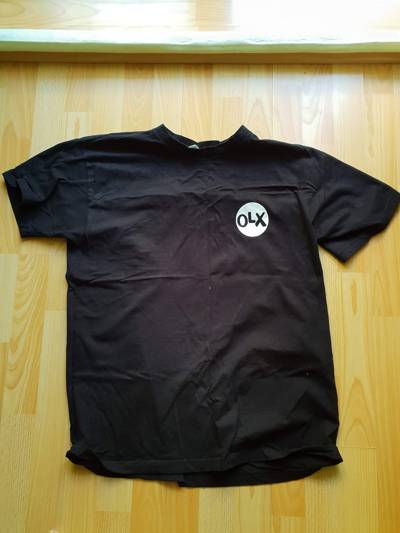

In [5]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = path + '/' + name
load_img(fullname)

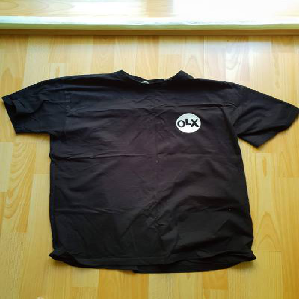

In [6]:
load_img(fullname, target_size=(299, 299))

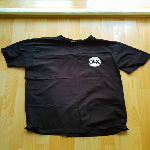

In [7]:
load_img(fullname, target_size=(150, 150))

In [8]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

In [9]:
model = MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3)
)

14540800/14536120 [==============================] - 0s 0us/step


In [10]:
img = load_img(fullname, target_size=(224, 224))
x = np.array(img)
x.shape

(224, 224, 3)

In [11]:
X = np.array([x])
X.shape

(1, 224, 224, 3)

In [12]:
X = preprocess_input(X)

In [13]:
pred = model.predict(X)

In [14]:
pred.shape

(1, 1000)

In [15]:
pred[0, :10]

array([4.0994113e-04, 2.6446862e-05, 3.9724160e-05, 2.5048648e-05,
       1.5226716e-05, 1.0567430e-04, 2.7054542e-05, 2.0510432e-05,
       1.2883768e-04, 1.1595695e-04], dtype=float32)

In [16]:
decode_predictions(pred)

40960/35363 [==================================] - 0s 0us/step


[[('n02916936', 'bulletproof_vest', 0.5632503),
  ('n04370456', 'sweatshirt', 0.123505324),
  ('n03595614', 'jersey', 0.11774085),
  ('n04235860', 'sleeping_bag', 0.08214962),
  ('n02769748', 'backpack', 0.021227993)]]

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
image_size = (150, 150)
batch_size = 32

In [19]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [20]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [21]:
base_model = MobileNetV2(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

9412608/9406464 [==============================] - 0s 0us/step


In [22]:
base_model.trainable = False

In [23]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vector)

model = keras.Model(inputs, outputs)

In [24]:
learning_rate = 0.01

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [25]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 16s 144ms/step - loss: 2.3585 - accuracy: 0.5644 - val_loss: 0.8903 - val_accuracy: 0.7977
Epoch 2/10
96/96 [==============================] - 12s 128ms/step - loss: 0.5540 - accuracy: 0.8423 - val_loss: 0.9953 - val_accuracy: 0.7947
Epoch 3/10
96/96 [==============================] - 12s 128ms/step - loss: 0.3273 - accuracy: 0.8996 - val_loss: 1.1030 - val_accuracy: 0.7742
Epoch 4/10
96/96 [==============================] - 12s 128ms/step - loss: 0.1901 - accuracy: 0.9372 - val_loss: 0.9446 - val_accuracy: 0.8006
Epoch 5/10
96/96 [==============================] - 12s 129ms/step - loss: 0.1418 - accuracy: 0.9540 - val_loss: 1.0866 - val_accuracy: 0.7889
Epoch 6/10
96/96 [==============================] - 12s 129ms/step - loss: 0.0964 - accuracy: 0.9620 - val_loss: 1.1303 - val_accuracy: 0.7742
Epoch 7/10
96/96 [==============================] - 12s 129ms/step - loss: 0.0600 - accuracy: 0.9797 - val_loss: 1.1102 - val_accuracy: 0.7889

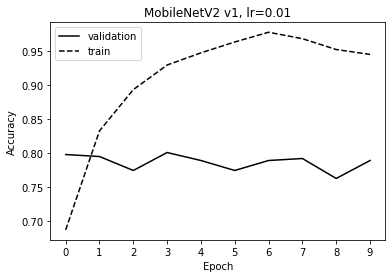

In [26]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('MobileNetV2 v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


plt.savefig('mobilenetv2_v1_0_01.svg')

plt.show()

In [27]:
def make_model(learning_rate):
    base_model = MobileNetV2(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [28]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 15s 139ms/step - loss: 1.6716 - accuracy: 0.4635 - val_loss: 0.7867 - val_accuracy: 0.7126
Epoch 2/10
96/96 [==============================] - 13s 130ms/step - loss: 0.5719 - accuracy: 0.8079 - val_loss: 0.6194 - val_accuracy: 0.7801
Epoch 3/10
96/96 [==============================] - 12s 129ms/step - loss: 0.4148 - accuracy: 0.8603 - val_loss: 0.5885 - val_accuracy: 0.7801
Epoch 4/10
96/96 [==============================] - 12s 128ms/step - loss: 0.3509 - accuracy: 0.8834 - val_loss: 0.5521 - val_accuracy: 0.7889
Epoch 5/10
96/96 [==============================] - 12s 129ms/step - loss: 0.2909 - accuracy: 0.9143 - val_loss: 0.5470 - val_accuracy: 0.7947
Epoch 6/10
96/96 [==============================] - 12s 129ms/step - loss: 0.2315 - accuracy: 0.9395 - val_loss: 0.5345 - val_accuracy: 0.8006
Epoch 7/10
96/96 [==============================] - 12s 130ms/step - loss: 0.2004 - accuracy: 0.9479 - val_loss: 0.5443 - val_accuracy: 0.8152

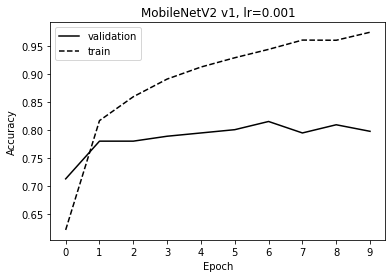

In [29]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('MobileNetV2 v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('mobilenetv2_v1_0_001.svg')

plt.show()

In [30]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 [==============================] - 15s 137ms/step - loss: 2.5097 - accuracy: 0.1859 - val_loss: 1.8726 - val_accuracy: 0.3724
Epoch 2/10
96/96 [==============================] - 12s 130ms/step - loss: 1.5669 - accuracy: 0.4901 - val_loss: 1.4162 - val_accuracy: 0.5543
Epoch 3/10
96/96 [==============================] - 13s 130ms/step - loss: 1.2319 - accuracy: 0.6004 - val_loss: 1.1710 - val_accuracy: 0.6188
Epoch 4/10
96/96 [==============================] - 12s 129ms/step - loss: 1.0280 - accuracy: 0.6605 - val_loss: 1.0210 - val_accuracy: 0.6686
Epoch 5/10
96/96 [==============================] - 12s 129ms/step - loss: 0.8903 - accuracy: 0.7074 - val_loss: 0.9188 - val_accuracy: 0.6921
Epoch 6/10
96/96 [==============================] - 12s 129ms/step - loss: 0.8083 - accuracy: 0.7344 - val_loss: 0.8512 - val_accuracy: 0.7038
Epoch 7/10
96/96 [==============================] - 12s 128ms/step - loss: 0.7330 - accuracy: 0.7629 - val_loss: 0.7911 - val_accuracy: 0.7361

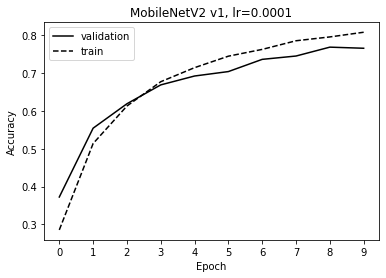

In [31]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('MobileNetV2 v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('mobilenetv2_v1_0_0001.svg')

plt.show()

In [32]:
epochs = np.arange(10)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

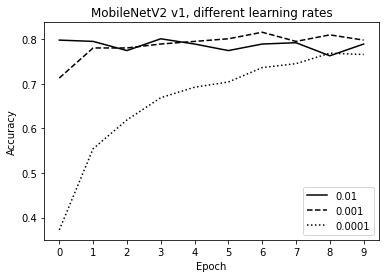

In [33]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('MobileNetV2 v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('mobilenetv2_v1_all_lr.svg')

plt.show()


In [ ]:
model = make_model(learning_rate=0.001)

In [35]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
96/96 [==============================] - 15s 136ms/step - loss: 1.5749 - accuracy: 0.4904 - val_loss: 0.6872 - val_accuracy: 0.7742
Epoch 2/10
96/96 [==============================] - 12s 128ms/step - loss: 0.5546 - accuracy: 0.8004 - val_loss: 0.5673 - val_accuracy: 0.8328
Epoch 3/10
96/96 [==============================] - 12s 129ms/step - loss: 0.4161 - accuracy: 0.8673 - val_loss: 0.5630 - val_accuracy: 0.8094
Epoch 4/10
96/96 [==============================] - 12s 128ms/step - loss: 0.3647 - accuracy: 0.8726 - val_loss: 0.5422 - val_accuracy: 0.8094
Epoch 5/10
96/96 [==============================] - 12s 128ms/step - loss: 0.2769 - accuracy: 0.9186 - val_loss: 0.5136 - val_accuracy: 0.8270
Epoch 6/10
96/96 [==============================] - 12s 127ms/step - loss: 0.2332 - accuracy: 0.9319 - val_loss: 0.5565 - val_accuracy: 0.8299
Epoch 7/10
96/96 [==============================] - 12s 128ms/step - loss: 0.2038 - accuracy: 0.9481 - val_loss: 0.5172 - val_accuracy: 0.8182

In [36]:
def make_model(learning_rate, droprate):
    base_model = MobileNetV2(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [ ]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

In [38]:
history_0 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 15s 137ms/step - loss: 1.3943 - accuracy: 0.5488 - val_loss: 0.5593 - val_accuracy: 0.8182
Epoch 2/30
96/96 [==============================] - 12s 129ms/step - loss: 0.4159 - accuracy: 0.8589 - val_loss: 0.5248 - val_accuracy: 0.8182
Epoch 3/30
96/96 [==============================] - 12s 130ms/step - loss: 0.2834 - accuracy: 0.9231 - val_loss: 0.5094 - val_accuracy: 0.8358
Epoch 4/30
96/96 [==============================] - 12s 129ms/step - loss: 0.1925 - accuracy: 0.9384 - val_loss: 0.5108 - val_accuracy: 0.8299
Epoch 5/30
96/96 [==============================] - 13s 130ms/step - loss: 0.1296 - accuracy: 0.9672 - val_loss: 0.5366 - val_accuracy: 0.8182
Epoch 6/30
96/96 [==============================] - 12s 130ms/step - loss: 0.0958 - accuracy: 0.9814 - val_loss: 0.5471 - val_accuracy: 0.8182
Epoch 7/30
96/96 [==============================] - 12s 128ms/step - loss: 0.0656 - accuracy: 0.9894 - val_loss: 0.6031 - val_accuracy: 0.8152

In [39]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 15s 137ms/step - loss: 1.5845 - accuracy: 0.5169 - val_loss: 0.6703 - val_accuracy: 0.7918
Epoch 2/30
96/96 [==============================] - 12s 129ms/step - loss: 0.5257 - accuracy: 0.8210 - val_loss: 0.4984 - val_accuracy: 0.8446
Epoch 3/30
96/96 [==============================] - 12s 129ms/step - loss: 0.3932 - accuracy: 0.8679 - val_loss: 0.5401 - val_accuracy: 0.8094
Epoch 4/30
96/96 [==============================] - 13s 130ms/step - loss: 0.2887 - accuracy: 0.8961 - val_loss: 0.4905 - val_accuracy: 0.8299
Epoch 5/30
96/96 [==============================] - 12s 129ms/step - loss: 0.2302 - accuracy: 0.9216 - val_loss: 0.4899 - val_accuracy: 0.8240
Epoch 6/30
96/96 [==============================] - 12s 128ms/step - loss: 0.2033 - accuracy: 0.9389 - val_loss: 0.5141 - val_accuracy: 0.8299
Epoch 7/30
96/96 [==============================] - 12s 129ms/step - loss: 0.1376 - accuracy: 0.9593 - val_loss: 0.5276 - val_accuracy: 0.8270

In [40]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 16s 142ms/step - loss: 1.8336 - accuracy: 0.4552 - val_loss: 0.7825 - val_accuracy: 0.7507
Epoch 2/30
96/96 [==============================] - 12s 129ms/step - loss: 0.8755 - accuracy: 0.7030 - val_loss: 0.5944 - val_accuracy: 0.8065
Epoch 3/30
96/96 [==============================] - 13s 130ms/step - loss: 0.6609 - accuracy: 0.7692 - val_loss: 0.5473 - val_accuracy: 0.7918
Epoch 4/30
96/96 [==============================] - 12s 129ms/step - loss: 0.5251 - accuracy: 0.8147 - val_loss: 0.5072 - val_accuracy: 0.8328
Epoch 5/30
96/96 [==============================] - 12s 130ms/step - loss: 0.4900 - accuracy: 0.8300 - val_loss: 0.4984 - val_accuracy: 0.8270
Epoch 6/30
96/96 [==============================] - 12s 130ms/step - loss: 0.4208 - accuracy: 0.8459 - val_loss: 0.4968 - val_accuracy: 0.8358
Epoch 7/30
96/96 [==============================] - 12s 130ms/step - loss: 0.3750 - accuracy: 0.8716 - val_loss: 0.5085 - val_accuracy: 0.8446

In [41]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Epoch 1/30
96/96 [==============================] - 15s 137ms/step - loss: 2.4415 - accuracy: 0.2795 - val_loss: 1.2369 - val_accuracy: 0.5660
Epoch 2/30
96/96 [==============================] - 12s 129ms/step - loss: 1.5466 - accuracy: 0.4554 - val_loss: 1.0205 - val_accuracy: 0.6364
Epoch 3/30
96/96 [==============================] - 12s 127ms/step - loss: 1.3190 - accuracy: 0.5213 - val_loss: 0.8969 - val_accuracy: 0.7038
Epoch 4/30
96/96 [==============================] - 12s 128ms/step - loss: 1.2448 - accuracy: 0.5346 - val_loss: 0.8878 - val_accuracy: 0.6833
Epoch 5/30
96/96 [==============================] - 12s 129ms/step - loss: 1.1767 - accuracy: 0.5582 - val_loss: 0.7794 - val_accuracy: 0.7654
Epoch 6/30
96/96 [==============================] - 12s 128ms/step - loss: 1.0809 - accuracy: 0.5996 - val_loss: 0.7643 - val_accuracy: 0.7654
Epoch 7/30
96/96 [==============================] - 12s 128ms/step - loss: 1.0983 - accuracy: 0.5981 - val_loss: 0.6962 - val_accuracy: 0.7507

In [42]:
epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

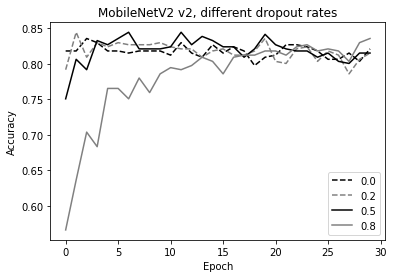

In [43]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('MobileNetV2 v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('mobilenetv2_v2_dropout.svg')

plt.show()

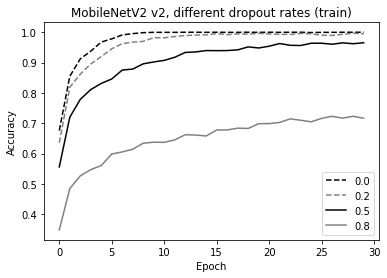

In [44]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('MobileNetV2 v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('mobilenetv2_v2_dropout_train.svg')

plt.show()

In [45]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [46]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [47]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "mobilenetv2_v3_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks)

Epoch 1/50
96/96 [==============================] - 28s 264ms/step - loss: 1.5488 - accuracy: 0.5173 - val_loss: 0.6458 - val_accuracy: 0.7742
Epoch 2/50
96/96 [==============================] - 25s 256ms/step - loss: 0.6489 - accuracy: 0.7773 - val_loss: 0.5693 - val_accuracy: 0.8006
Epoch 3/50
96/96 [==============================] - 25s 256ms/step - loss: 0.5441 - accuracy: 0.8169 - val_loss: 0.5288 - val_accuracy: 0.7977
Epoch 4/50
96/96 [==============================] - 25s 258ms/step - loss: 0.4351 - accuracy: 0.8386 - val_loss: 0.5037 - val_accuracy: 0.8152
Epoch 5/50
96/96 [==============================] - 25s 256ms/step - loss: 0.3820 - accuracy: 0.8608 - val_loss: 0.4746 - val_accuracy: 0.8387
Epoch 6/50
96/96 [==============================] - 25s 255ms/step - loss: 0.3229 - accuracy: 0.8785 - val_loss: 0.5145 - val_accuracy: 0.8240
Epoch 7/50
96/96 [==============================] - 25s 255ms/step - loss: 0.2859 - accuracy: 0.9039 - val_loss: 0.5287 - val_accuracy: 0.8152

In [48]:
epochs = history.epoch
accuracy = history.history['val_accuracy']

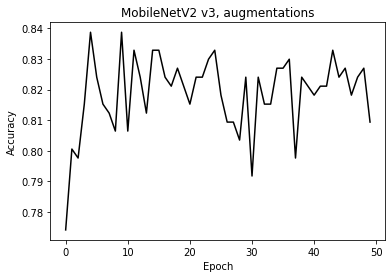

In [49]:
plt.plot(epochs, accuracy, color='black', linestyle='solid')


plt.title('MobileNetV2 v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('mobilenetv2_v3_aug.svg')

plt.show()

In [50]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [51]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [52]:
labels = {
    0: 'dress',
    1: 'hat',
    2: 'longsleeve',
    3: 'outwear',
    4: 'pants',
    5: 'shirt',
    6: 'shoes',
    7: 'shorts',
    8: 'skirt',
    9: 't-shirt'
}

In [53]:
image_size = (150, 150)

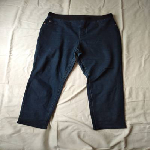

In [54]:
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
img = load_img(path, target_size=(image_size))
img

In [55]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [56]:
pred = model.predict(X)
pred[0]

array([ -5.2702065, -12.8231945,  -2.3463342,  -4.9838524,  15.268139 ,
        -1.5389906,  -8.432856 ,   4.6625676,  -4.9201784,  -7.9895225],
      dtype=float32)

In [57]:
pred[0].argmax()

4

In [58]:
labels[pred[0].argmax()]

'pants'

In [59]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    "clothing-dataset-small/test",
    shuffle=False,
    target_size=image_size,
    batch_size=32,
)

Found 372 images belonging to 10 classes.


In [60]:
model.evaluate(test_ds)

12/12 [==============================] - 2s 141ms/step - loss: 0.7726 - accuracy: 0.8118


[0.7725673317909241, 0.8118279576301575]

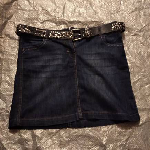

In [61]:
path = '/content/clothing-dataset-small/test/skirt/491982c3-3e90-431e-99e6-b14ecea36384.jpg'
img = load_img(path, target_size=(image_size))
img

In [62]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [63]:
pred = model.predict(X)
pred[0]

array([ -1.9022213 ,  -7.1399674 ,  -5.807382  ,  -7.759221  ,
         0.56516093,  -7.514975  , -10.218565  ,   2.6350777 ,
         9.166027  ,   0.60105634], dtype=float32)

In [64]:
pred[0].argmax()

8

In [65]:
labels[pred[0].argmax()]

'skirt'

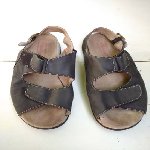

In [66]:
path = '/content/clothing-dataset-small/test/shoes/2174d585-e8cf-43ce-bb61-de1567c74fd5.jpg'
img = load_img(path, target_size=(image_size))
img

In [67]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [68]:
pred = model.predict(X)
pred[0]

array([-10.410041 ,  -2.8866928, -10.083257 ,  -2.2403731,   2.1986992,
        -7.9743443,  28.869875 ,  -9.632017 ,  -8.860569 , -19.865383 ],
      dtype=float32)

In [69]:
pred[0].argmax()

6

In [70]:
labels[pred[0].argmax()]

'shoes'

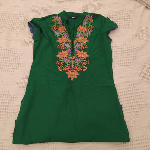

In [71]:
path = '/content/clothing-dataset-small/test/dress/bac70656-a50a-4a13-8c3f-63e3a0a28338.jpg'
img = load_img(path, target_size=(image_size))
img

In [72]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [73]:
pred = model.predict(X)
pred[0]

array([ 16.027218 , -10.977618 ,  -1.9945153,  -2.8272674, -11.797136 ,
        -6.9679093,  -9.701777 , -10.277303 ,  -8.423865 ,  11.605596 ],
      dtype=float32)

In [74]:
pred[0].argmax()
labels[pred[0].argmax()]

'dress'

In [75]:
pred[0].argmax()

0

In [82]:
#Import your test images to colab. I use pinterest to store the the images. 
%mkdir /content/test/
%cd /content/test/

!curl -L "https://images.unsplash.com/photo-1572804013309-59a88b7e92f1?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=684&q=80.jpg" > test.jpeg;

/content/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 89258  100 89258    0     0   645k      0 --:--:-- --:--:-- --:--:--  645k


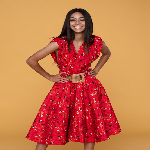

In [83]:
path = '/content/test/test.jpeg'
img = load_img(path, target_size=(image_size))
img

In [84]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

pred = model.predict(X)
pred[0]

array([  9.10465  , -13.6610365,   0.484851 ,   2.2716918,  -6.336615 ,
         2.722344 , -13.7476225,  -8.278543 ,  -3.1244264,  -9.807308 ],
      dtype=float32)

In [85]:
pred[0].argmax()

0

In [86]:
labels[pred[0].argmax()]

'dress'

In [87]:
#Import your test images to colab. I use pinterest to store the the images. 
%mkdir /content/test/
%cd /content/test/

!curl -L "https://st4.depositphotos.com/13193658/27067/i/1600/depositphotos_270674086-stock-photo-beautiful-smiling-teenage-girl-looking.jpg" > test.jpeg;

mkdir: cannot create directory ‘/content/test/’: File exists
/content/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  112k  100  112k    0     0   880k      0 --:--:-- --:--:-- --:--:--  880k


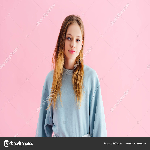

In [88]:
path = '/content/test/test.jpeg'
img = load_img(path, target_size=(image_size))
img

In [89]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

pred = model.predict(X)
pred[0]

array([ -0.33029026,  -4.7543135 ,  -1.8571501 ,   4.3661513 ,
         4.144115  ,  -2.8937998 ,  -5.3861346 ,  -1.8185698 ,
        -1.461781  , -11.365563  ], dtype=float32)

In [90]:
pred[0].argmax()

3

In [91]:
labels[pred[0].argmax()]

'outwear'

In [92]:
#Import your test images to colab. I use pinterest to store the the images. 
%mkdir /content/test/
%cd /content/test/

!curl -L "https://m.media-amazon.com/images/G/01/Shopbop/p/prod/products/cameo/cameo305691071c/cameo305691071c_q6_2-0._UX357_QL90_.jpg" > test.jpeg;

mkdir: cannot create directory ‘/content/test/’: File exists
/content/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20753  100 20753    0     0   750k      0 --:--:-- --:--:-- --:--:--  750k


In [93]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 112kB 27.5MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [94]:
model.save("model.h5")

In [95]:
!tensorflowjs_converter --input_format=keras /content/test/model.h5 /tmp/tfjs_model

2021-04-27 19:03:38.189208: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [96]:
!tensorflowjs_converter --input_format tfjs_layers_model --output_format tfjs_graph_model /tmp/tfjs_model/model.json graph_model

2021-04-27 19:03:42.561429: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-27 19:03:44.316716: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-27 19:03:44.317713: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-27 19:03:44.323071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 19:03:44.323581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-04-27 19:03:44.323620: I tensorflow/stream_executor/platform/default/dso_loade

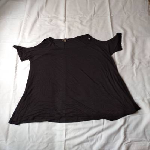

In [97]:
path = '/content/clothing-dataset-small/test/t-shirt/29cffc8e-5e72-4b73-bbc0-20b9f1251bc2.jpg'
img = load_img(path, target_size=(image_size))
img

In [98]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [99]:
pred = model.predict(X)
pred[0]

array([  6.2441516,  -9.907711 ,   3.5065832,  -8.384421 , -10.142815 ,
        -4.6664357, -12.778396 , -10.295438 ,  -7.4815445,  15.268044 ],
      dtype=float32)

In [100]:
pred[0].argmax()
labels[pred[0].argmax()]

't-shirt'

In [101]:
pred[0].argmax()

9

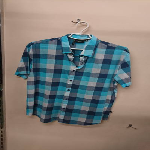

In [102]:
path = '/content/clothing-dataset-small/test/shirt/61086848-70bf-462f-87e0-0f756adbd03d.jpg'
img = load_img(path, target_size=(image_size))
img

In [103]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)

In [104]:
pred = model.predict(X)
pred[0]

array([ -4.9419065,  -6.002426 ,   2.8584485,  -1.95552  ,  -7.367037 ,
         8.955335 , -10.181653 ,  -3.4966574,  -7.7798443,   1.3386977],
      dtype=float32)

In [105]:
pred[0].argmax()

5

In [106]:
pred[0].argmax()
labels[pred[0].argmax()]

'shirt'